In [47]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns
from sklearn.feature_selection import SelectKBest,f_classif

#Trzeba te labels dobrze dać
#15N 15H 15A 15N

# LOAD DATA

In [48]:
DATA_PATH = "BazaCut/"
FILIP_PATH = DATA_PATH + "sentencesFilip/"
SEB_PATH = DATA_PATH + "sentencesSebastian/"
MARCIN_PATH = DATA_PATH + "sentencesMarcin/"
PROF_PATH = DATA_PATH + "sentencesProfessor/"
no_of_sentences = 45
prefixes = ["F","S","M","L"]
Fs = 48000
sentences_filip = [i for i in range(no_of_sentences)]
sentences_seb = [i for i in range(no_of_sentences)]
sentences_marcin = [i for i in range(no_of_sentences)]
sentences_prof = [i for i in range(no_of_sentences)]

neutral = ["N"]*15
happy = ["H"] *15
anger = ["A"] *15
L = neutral+happy+anger


for i in range(1, no_of_sentences+1):
    file_name = "sentence"+str(i)+L[i-1]+"_F"+".wav"
    y, sr = librosa.load(FILIP_PATH+file_name, sr=None)
    sentences_filip[i-1] = y

for i in range(1, no_of_sentences+1):
    file_name = "sentence"+str(i)+L[i-1]+"_S"+".wav"
    y, sr = librosa.load(SEB_PATH+file_name, sr=None)
    sentences_seb[i-1] = y

for i in range(1, no_of_sentences+1):
    file_name = "sentence"+str(i)+L[i-1]+"_M"+".wav"
    y, sr = librosa.load(MARCIN_PATH+file_name, sr=None)
    sentences_marcin[i-1] = y

for i in range(1, no_of_sentences+1):
    file_name = "sentence"+str(i)+L[i-1]+"_L"+".wav"
    y, sr = librosa.load(PROF_PATH+file_name, sr=None)
    sentences_prof[i-1] = y


# MFCC (Mel Frequency Cepstral Coefficients) and Deltta MFCC

In [49]:
# Ekstrakcja MFCC (np. 13 współczynników)
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Dodatkowe cechy: delty MFCC
delta_mfcc = librosa.feature.delta(mfcc)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

# Połączenie cech w jedną macierz
features = np.concatenate([mfcc, delta_mfcc, delta2_mfcc], axis=0)

mfcc_features_no = 13
#Problem: w wyniku mfcc mamy macierz (13,x). Ilość kolumn dla każdego słowa jest inna. Nie da się 
#dać do numpy array
mfcc_filip = [i for i in range(no_of_sentences)]
mfcc_delta_filip = [i for i in range(no_of_sentences)]
mfcc_delta2_filip = [i for i in range(no_of_sentences)]
for i, word in enumerate(sentences_filip):
    mfcc_filip[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_filip[i] = librosa.feature.delta(mfcc_filip[i])
    mfcc_delta2_filip[i] =  librosa.feature.delta(mfcc_filip[i], order=2)


mfcc_seb = [i for i in range(no_of_sentences)]
mfcc_delta_seb = [i for i in range(no_of_sentences)]
mfcc_delta2_seb = [i for i in range(no_of_sentences)]

for i, word in enumerate(sentences_seb):
    mfcc_seb[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_seb[i] = librosa.feature.delta(mfcc_seb[i])
    mfcc_delta2_seb[i] =  librosa.feature.delta(mfcc_seb[i], order=2)

mfcc_marcin = [i for i in range(no_of_sentences)]
mfcc_delta_marcin = [i for i in range(no_of_sentences)]
mfcc_delta2_marcin = [i for i in range(no_of_sentences)]
for i, word in enumerate(sentences_marcin):
    mfcc_marcin[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_marcin[i] = librosa.feature.delta(mfcc_marcin[i])
    mfcc_delta2_marcin[i] =  librosa.feature.delta(mfcc_marcin[i], order=2)


mfcc_prof = [i for i in range(no_of_sentences)]
mfcc_delta_prof = [i for i in range(no_of_sentences)]
mfcc_delta2_prof = [i for i in range(no_of_sentences)]
for i, word in enumerate(sentences_prof):
    mfcc_prof[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_prof[i] = librosa.feature.delta(mfcc_prof[i])
    mfcc_delta2_prof[i] =  librosa.feature.delta(mfcc_prof[i], order=2)

# Using SVM

In [50]:
mfcc_filip_mean = np.zeros((no_of_sentences,mfcc_features_no))
mfcc_seb_mean = np.zeros((no_of_sentences,mfcc_features_no))
mfcc_marcin_mean= np.zeros((no_of_sentences,mfcc_features_no))
mfcc_prof_mean= np.zeros((no_of_sentences,mfcc_features_no))


for i in range(no_of_sentences):
    mfcc_filip_mean[i,0:mfcc_features_no] = np.mean(mfcc_filip[i],axis=1)
    mfcc_seb_mean[i,0:mfcc_features_no] = np.mean(mfcc_seb[i],axis=1)
    mfcc_marcin_mean[i,0:mfcc_features_no] = np.mean(mfcc_marcin[i],axis=1)
    mfcc_prof_mean[i,0:mfcc_features_no] = np.mean(mfcc_prof[i],axis=1)

feature_vector = np.concatenate((mfcc_filip_mean, mfcc_seb_mean,mfcc_marcin_mean,mfcc_prof_mean))



labelsN = np.zeros(15)
labelsH = np.zeros(15)+1
labelsA = np.zeros(15)+2
labels1 = np.concatenate((labelsN, labelsH,labelsA))
labels = np.concatenate((labels1, labels1,labels1,labels1))

In [51]:
X_train, X_test, y_train, y_test = train_test_split(feature_vector, labels, test_size=0.6, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svm = SVC(kernel='linear', C=1.0, random_state=42)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6296296296296297
              precision    recall  f1-score   support

         0.0       0.76      0.86      0.81        36
         1.0       0.54      0.39      0.45        36
         2.0       0.56      0.64      0.60        36

    accuracy                           0.63       108
   macro avg       0.62      0.63      0.62       108
weighted avg       0.62      0.63      0.62       108



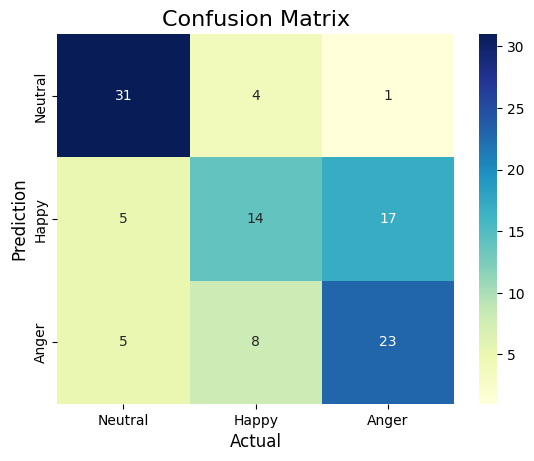

In [52]:
cm = confusion_matrix(y_test, y_pred)
ticks = ["Neutral","Happy","Anger"]

sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Random Forest

In [53]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6759259259259259
              precision    recall  f1-score   support

         0.0       0.82      0.92      0.87        36
         1.0       0.59      0.53      0.56        36
         2.0       0.58      0.58      0.58        36

    accuracy                           0.68       108
   macro avg       0.67      0.68      0.67       108
weighted avg       0.67      0.68      0.67       108



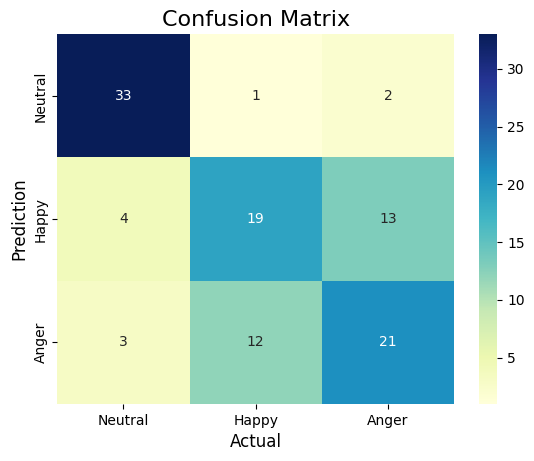

In [54]:
cm = confusion_matrix(y_test, y_pred)
ticks = ["Neutral","Happy","Anger"]

sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Multilayer Perceptron

In [55]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(100, 100,100), activation='relu', solver='adam', 
                         max_iter=2000, random_state=42)
mlp_clf.fit(X_train, y_train)
mlp_pred = mlp_clf.predict(X_test)

print("MLP Accuracy:", accuracy_score(y_test, mlp_pred))
print("MLP Classification Report:\n", classification_report(y_test, mlp_pred))

MLP Accuracy: 0.8148148148148148
MLP Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.94      0.89        36
         1.0       0.81      0.72      0.76        36
         2.0       0.78      0.78      0.78        36

    accuracy                           0.81       108
   macro avg       0.81      0.81      0.81       108
weighted avg       0.81      0.81      0.81       108



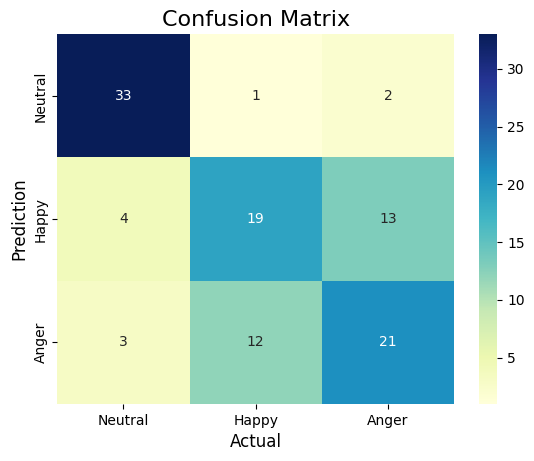

In [56]:
cm = confusion_matrix(y_test, y_pred)
ticks = ["Neutral","Happy","Anger"]

sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Spectral Features
### Spectral Centroid, Spectral Bandwidth, Spectral Contrast, Spectral Flatness

In [57]:
spectral_features_no = 4

spectral_features_filip = [i for i in range(no_of_sentences)]
for i, word in enumerate(sentences_filip):
    spectral_features_vector = np.zeros(4)
    spectral_features_vector[0] = np.mean(librosa.feature.spectral_centroid(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[1] = np.mean(librosa.feature.spectral_bandwidth(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[2] = np.mean(librosa.feature.spectral_contrast(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[3] = np.mean(librosa.feature.spectral_flatness(y=word),axis=1)[0]
    spectral_features_filip[i] = spectral_features_vector

spectral_features_seb = [i for i in range(no_of_sentences)]
for i, word in enumerate(sentences_seb):
    spectral_features_vector = np.zeros(4)
    spectral_features_vector[0] = np.mean(librosa.feature.spectral_centroid(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[1] = np.mean(librosa.feature.spectral_bandwidth(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[2] = np.mean(librosa.feature.spectral_contrast(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[3] = np.mean(librosa.feature.spectral_flatness(y=word),axis=1)[0]
    spectral_features_seb[i] = spectral_features_vector


spectral_features_marcin = [i for i in range(no_of_sentences)]
for i, word in enumerate(sentences_marcin):
    spectral_features_vector = np.zeros(4)
    spectral_features_vector[0] = np.mean(librosa.feature.spectral_centroid(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[1] = np.mean(librosa.feature.spectral_bandwidth(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[2] = np.mean(librosa.feature.spectral_contrast(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[3] = np.mean(librosa.feature.spectral_flatness(y=word),axis=1)[0]
    spectral_features_marcin[i] = spectral_features_vector

spectral_features_prof = [i for i in range(no_of_sentences)]
for i, word in enumerate(sentences_prof):
    spectral_features_vector = np.zeros(4)
    spectral_features_vector[0] = np.mean(librosa.feature.spectral_centroid(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[1] = np.mean(librosa.feature.spectral_bandwidth(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[2] = np.mean(librosa.feature.spectral_contrast(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[3] = np.mean(librosa.feature.spectral_flatness(y=word),axis=1)[0]
    spectral_features_prof[i] = spectral_features_vector


feature_vector = np.concatenate((spectral_features_filip, spectral_features_seb,spectral_features_marcin,spectral_features_prof))
feature_vector.shape

(180, 4)

# SVM

In [58]:
X_train, X_test, y_train, y_test = train_test_split(feature_vector, labels, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svm = SVC(kernel='linear', C=1.0, random_state=42)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.4222222222222222
              precision    recall  f1-score   support

         0.0       0.49      0.60      0.54        30
         1.0       0.00      0.00      0.00        33
         2.0       0.38      0.74      0.50        27

    accuracy                           0.42        90
   macro avg       0.29      0.45      0.35        90
weighted avg       0.28      0.42      0.33        90



c:\Users\filip\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\filip\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\filip\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

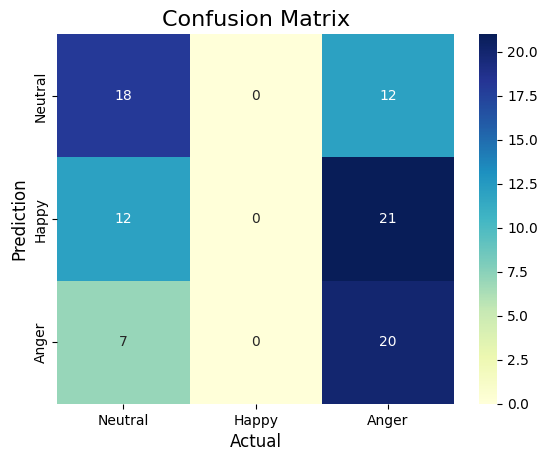

In [59]:
cm = confusion_matrix(y_test, y_pred)
ticks = ["Neutral","Happy","Anger"]

sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Random Forest

In [60]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5222222222222223
              precision    recall  f1-score   support

         0.0       0.56      0.77      0.65        30
         1.0       0.47      0.21      0.29        33
         2.0       0.50      0.63      0.56        27

    accuracy                           0.52        90
   macro avg       0.51      0.54      0.50        90
weighted avg       0.51      0.52      0.49        90



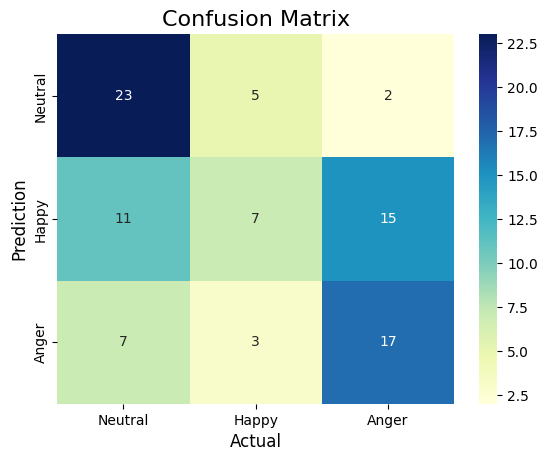

In [61]:
cm = confusion_matrix(y_test, y_pred)
ticks = ["Neutral","Happy","Anger"]

sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Multilayer Perceptron

In [62]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,100,100,20), activation='relu', solver='adam', 
                         max_iter=3000, random_state=42)
mlp_clf.fit(X_train, y_train)


mlp_pred = mlp_clf.predict(X_test)
print("MLP Accuracy:", accuracy_score(y_test, mlp_pred))
print("MLP Classification Report:\n", classification_report(y_test, mlp_pred))

MLP Accuracy: 0.5333333333333333
MLP Classification Report:
               precision    recall  f1-score   support

         0.0       0.62      0.67      0.65        30
         1.0       0.50      0.39      0.44        33
         2.0       0.47      0.56      0.51        27

    accuracy                           0.53        90
   macro avg       0.53      0.54      0.53        90
weighted avg       0.53      0.53      0.53        90



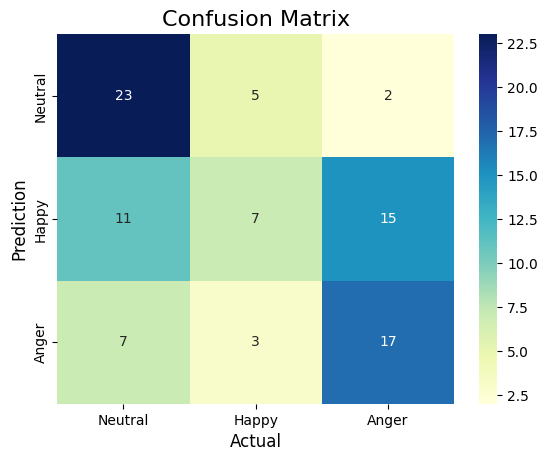

In [63]:
cm = confusion_matrix(y_test, y_pred)
ticks = ["Neutral","Happy","Anger"]

sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Feature Select
## Do wybrania najelpszeych cech użyto SelectKBest - wybranie najlepszych k cech na podstawie danego krytetrium

In [64]:
#Funckja do spłaszczania tablicy 3d do 2d. Robi flatten na ostatnich dwóch wymiarach
def flatten_features(data,X,Y,Z):

    mfcc_cut = np.zeros((X,Y,Z))
    mfcc_final = np.zeros((X,Y*Z))

    for i in range(X):
        for j in range(Y):
            mfcc_cut[i][j] =  data[i][j][:Z]

        to_flatten =  mfcc_cut[i]
        mfcc_final[i] = to_flatten.flatten()
    return mfcc_final

## MFCC

In [65]:
mfcc_features_no = 13
mfcc_filip = [i for i in range(no_of_sentences)]
mfcc_delta_filip = [i for i in range(no_of_sentences)]
mfcc_delta2_filip = [i for i in range(no_of_sentences)]
for i, word in enumerate(sentences_filip):
    mfcc_filip[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_filip[i] = librosa.feature.delta(mfcc_filip[i])
    mfcc_delta2_filip[i] =  librosa.feature.delta(mfcc_filip[i], order=2)


mfcc_seb = [i for i in range(no_of_sentences)]
mfcc_delta_seb = [i for i in range(no_of_sentences)]
mfcc_delta2_seb = [i for i in range(no_of_sentences)]
for i, word in enumerate(sentences_seb):
    mfcc_seb[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_seb[i] = librosa.feature.delta(mfcc_seb[i])
    mfcc_delta2_seb[i] =  librosa.feature.delta(mfcc_seb[i], order=2)

mfcc_marcin = [i for i in range(no_of_sentences)]
mfcc_delta_marcin = [i for i in range(no_of_sentences)]
mfcc_delta2_marcin = [i for i in range(no_of_sentences)]
for i, word in enumerate(sentences_marcin):
    mfcc_marcin[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_marcin[i] = librosa.feature.delta(mfcc_marcin[i])
    mfcc_delta2_marcin[i] =  librosa.feature.delta(mfcc_marcin[i], order=2)


mfcc_prof = [i for i in range(no_of_sentences)]
mfcc_delta_prof = [i for i in range(no_of_sentences)]
mfcc_delta2_prof = [i for i in range(no_of_sentences)]
for i, word in enumerate(sentences_prof):
    mfcc_prof[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_prof[i] = librosa.feature.delta(mfcc_prof[i])
    mfcc_delta2_prof[i] =  librosa.feature.delta(mfcc_prof[i], order=2)

# Macierze mfcc mają wymiar (30,13,x), gdzie x ma różną długość dla każdego słowwa.
# Może obciąż wszystkie dla najmniejszej długości
# to może ograniczyć i zrobić flatten
least_to_take = 200

mfcc_filip_final = flatten_features(mfcc_filip, no_of_sentences, mfcc_features_no,least_to_take)
mfcc_seb_final = flatten_features(mfcc_seb, no_of_sentences, mfcc_features_no,least_to_take)
mfcc_marcin_final = flatten_features(mfcc_marcin, no_of_sentences, mfcc_features_no,least_to_take)
mfcc_prof_final = flatten_features(mfcc_prof, no_of_sentences, mfcc_features_no,least_to_take)


mfcc_delta_filip_final = flatten_features(mfcc_delta_filip, no_of_sentences, mfcc_features_no,least_to_take)
mfcc_delta_seb_final = flatten_features(mfcc_delta_seb, no_of_sentences, mfcc_features_no,least_to_take)
mfcc_delta_marcin_final = flatten_features(mfcc_delta_marcin, no_of_sentences, mfcc_features_no,least_to_take)
mfcc_delta_prof_final = flatten_features(mfcc_delta_prof, no_of_sentences, mfcc_features_no,least_to_take)

mfcc_delta2_filip_final = flatten_features(mfcc_delta2_filip, no_of_sentences, mfcc_features_no,least_to_take)
mfcc_delta2_seb_final = flatten_features(mfcc_delta2_seb, no_of_sentences, mfcc_features_no,least_to_take)
mfcc_delta2_marcin_final = flatten_features(mfcc_delta2_marcin, no_of_sentences, mfcc_features_no,least_to_take)
mfcc_delta2_prof_final = flatten_features(mfcc_delta2_prof, no_of_sentences, mfcc_features_no,least_to_take)





feature_vector_mfcc = np.concatenate((mfcc_filip_final, mfcc_seb_final,mfcc_marcin_final,mfcc_prof_final))
feature_vector_mfcc_delta = np.concatenate((mfcc_delta_filip_final, mfcc_delta_seb_final,mfcc_delta_marcin_final,mfcc_delta_prof_final))
feature_vector_mfcc_delta2 = np.concatenate((mfcc_delta2_filip_final, mfcc_delta2_seb_final,mfcc_delta2_marcin_final,mfcc_delta2_prof_final))

feature_vector_mfcc = np.concatenate((feature_vector_mfcc, feature_vector_mfcc_delta,feature_vector_mfcc_delta2), axis=1)

print(feature_vector_mfcc.shape)

(180, 7800)


## Przykład użycia SelectKBest

# SVM 

In [66]:
X_train, X_test, y_train, y_test = train_test_split(feature_vector_mfcc, labels, test_size=0.2, random_state=42)

selector = SelectKBest(score_func=f_classif, k=2500)  
X_train_selected = selector.fit_transform(X_train, y_train)  
X_test_selected = selector.transform(X_test)  

scaler = StandardScaler()
X_train_selected = scaler.fit_transform(X_train_selected)
X_test_selected = scaler.transform(X_test_selected)

svm = SVC(kernel='sigmoid', C=1.0, random_state=42)
svm.fit(X_train_selected, y_train)
y_pred = svm.predict(X_test_selected)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5277777777777778
              precision    recall  f1-score   support

         0.0       0.79      0.85      0.81        13
         1.0       0.50      0.33      0.40        15
         2.0       0.25      0.38      0.30         8

    accuracy                           0.53        36
   macro avg       0.51      0.52      0.50        36
weighted avg       0.55      0.53      0.53        36



## Spectral

In [67]:
spectral_features_no = 4

spectral_features_filip = [i for i in range(no_of_sentences)]
for i, word in enumerate(sentences_filip):
    spectral_features_vector = [0]*10
    spectral_features_vector[0] = librosa.feature.spectral_centroid(y=word, sr=sr)[0]
    spectral_features_vector[1] = librosa.feature.spectral_bandwidth(y=word, sr=sr)[0]
    for j in range(2,9):
        spectral_features_vector[j] = librosa.feature.spectral_contrast(y=word, sr=sr)[j-3]
    spectral_features_vector[9] = librosa.feature.spectral_flatness(y=word)[0]
    spectral_features_filip[i] = spectral_features_vector

spectral_features_seb = [i for i in range(no_of_sentences)]
for i, word in enumerate(sentences_seb):
    spectral_features_vector = [0]*10
    spectral_features_vector[0] = librosa.feature.spectral_centroid(y=word, sr=sr)[0]
    spectral_features_vector[1] = librosa.feature.spectral_bandwidth(y=word, sr=sr)[0]
    for j in range(2,9):
        spectral_features_vector[j] = librosa.feature.spectral_contrast(y=word, sr=sr)[j-3]
    spectral_features_vector[9] = librosa.feature.spectral_flatness(y=word)[0]
    spectral_features_seb[i] = spectral_features_vector


spectral_features_marcin = [i for i in range(no_of_sentences)]
for i, word in enumerate(sentences_marcin):
    spectral_features_vector = [0]*10
    spectral_features_vector[0] = librosa.feature.spectral_centroid(y=word, sr=sr)[0]
    spectral_features_vector[1] = librosa.feature.spectral_bandwidth(y=word, sr=sr)[0]
    for j in range(2,9):
        spectral_features_vector[j] = librosa.feature.spectral_contrast(y=word, sr=sr)[j-3]
    spectral_features_vector[9] = librosa.feature.spectral_flatness(y=word)[0]
    spectral_features_marcin[i] = spectral_features_vector

spectral_features_prof= [i for i in range(no_of_sentences)]
for i, word in enumerate(sentences_prof):
    spectral_features_vector = [0]*10
    spectral_features_vector[0] = librosa.feature.spectral_centroid(y=word, sr=sr)[0]
    spectral_features_vector[1] = librosa.feature.spectral_bandwidth(y=word, sr=sr)[0]
    for j in range(2,9):
        spectral_features_vector[j] = librosa.feature.spectral_contrast(y=word, sr=sr)[j-3]
    spectral_features_vector[9] = librosa.feature.spectral_flatness(y=word)[0]
    spectral_features_prof[i] = spectral_features_vector


least_to_take = 200

spectral_filip_final = flatten_features(spectral_features_filip, no_of_sentences, 10, least_to_take)
spectral_seb_final = flatten_features(spectral_features_seb, no_of_sentences, 10, least_to_take)
spectral_marcin_final = flatten_features(spectral_features_marcin, no_of_sentences, 10, least_to_take)
spectral_prof_final = flatten_features(spectral_features_prof, no_of_sentences, 10, least_to_take)

feature_vector_spec = np.concatenate((spectral_filip_final, spectral_seb_final,spectral_marcin_final,spectral_prof_final))

In [68]:
X_train, X_test, y_train, y_test = train_test_split(feature_vector_spec, labels, test_size=0.2, random_state=42)

selector = SelectKBest(score_func=f_classif, k=400)  
X_train_selected = selector.fit_transform(X_train, y_train)  
X_test_selected = selector.transform(X_test)  

scaler = StandardScaler()
X_train_selected = scaler.fit_transform(X_train_selected)
X_test_selected = scaler.transform(X_test_selected)

svm = SVC(kernel='sigmoid', C=1.0, random_state=42)
svm.fit(X_train_selected, y_train)
y_pred = svm.predict(X_test_selected)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.3611111111111111
              precision    recall  f1-score   support

         0.0       0.50      0.54      0.52        13
         1.0       0.23      0.20      0.21        15
         2.0       0.33      0.38      0.35         8

    accuracy                           0.36        36
   macro avg       0.35      0.37      0.36        36
weighted avg       0.35      0.36      0.35        36



## Połączenie MFCC i Spectral

In [69]:
feature_vector = np.concatenate((feature_vector_mfcc, feature_vector_spec), axis=1)

X_train, X_test, y_train, y_test = train_test_split(feature_vector, labels, test_size=0.2, random_state=42)

selector = SelectKBest(score_func=f_classif, k=6000)  
X_train_selected = selector.fit_transform(X_train, y_train)  
X_test_selected = selector.transform(X_test)  

scaler = StandardScaler()
X_train_selected = scaler.fit_transform(X_train_selected)
X_test_selected = scaler.transform(X_test_selected)

svm = SVC(kernel='linear', C=1.0, random_state=42)
svm.fit(X_train_selected, y_train)
y_pred = svm.predict(X_test_selected)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5
              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85        13
         1.0       0.42      0.33      0.37        15
         2.0       0.18      0.25      0.21         8

    accuracy                           0.50        36
   macro avg       0.48      0.48      0.48        36
weighted avg       0.52      0.50      0.51        36

